In [1]:
using Revise
using SourceSeparationNF
using MLDatasets
using LinearAlgebra
using ProgressMeter
using Statistics
using PyPlot

BLAS.set_num_threads(1)

┌ Info: Precompiling SourceSeparationNF [0967cf83-991d-4407-9a5d-c519cfeee958]
└ @ Base loading.jl:1423


In [2]:
# fetch data
train_x, train_y = MNIST.traindata(dir = "../data/MNIST");

In [3]:
function create_neural_network(dim)

    return Model(dim,
        (
            DenseLayer(dim, 8),
            ReluLayer(8),
            DenseLayer(8, 8),
            ReluLayer(8),
            DenseLayer(8, dim)
        )
    )

end

create_neural_network (generic function with 1 method)

In [4]:
model = Model(
    28*28,
    10,
    (
        MvAdditiveLayer(28*28, create_neural_network(28*14)),
        PermutationLayer(28*28),
        MvAdditiveLayer(28*28, create_neural_network(28*14)),
        DenseLayer(28*28, 10),
        SoftmaxLayer(10)
    )
);

In [5]:
setlr!(model, 1e-3)

In [6]:
# allocate for input image
input = Matrix{Float64}(undef, 28, 28)
output = Vector{Float64}(undef, 10)
loss_function = CCE();

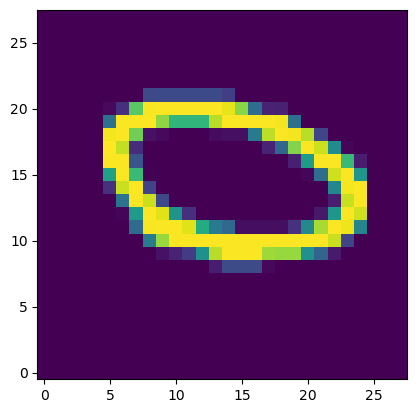

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall C:\Users\s151781\.julia\packages\PyCall\L0fLP\src\numpy.jl:67


10-element Vector{Float64}:
 0.06891873306788848
 0.10214373586000035
 0.2047636780920886
 0.0758552693727309
 0.0629271791109227
 0.09668547843361261
 0.06733246809653579
 0.06822416802891293
 0.09653670849671342
 0.15661258144059434

In [7]:
# show initial prediction
using StatsFuns: softmax
input = convert(Matrix{Float64}, train_x[:,:,1001])
plt.imshow(input, origin="lower")
softmax(forward!(model, vec(input)))

In [8]:
loss = Vector{Float64}(undef, 60_000)
@showprogress for epoch in 1:50
    for k in 1:60_000
        # load data
        input .= train_x[:,:,k]
        output .= 0.0
        output[train_y[k]+1] = 1.0

        # train model
        loss[k] = train!(model, vec(input), output, loss_function)
    end
    println("epoch ", lpad(epoch, 3, "0"), ": ", mean(loss))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:02:31


epoch 001: 0.2161620417068751
epoch 002: 0.1769157551467923
epoch 003: 0.14990534531438077
epoch 004: 0.13088421846901602
epoch 005: 0.11707480606461253
epoch 006: 0.10669303739737582
epoch 007: 0.09863568333505993
epoch 008: 0.09220932610013449
epoch 009: 0.086964348387057
epoch 010: 0.08259871249488743
epoch 011: 0.07890414679155759
epoch 012: 0.07573259494271327
epoch 013: 0.07297756321463177
epoch 014: 0.07055866480062634
epoch 015: 0.06841457948087812
epoch 016: 0.0664978433277237
epoch 017: 0.06477262247579409
epoch 018: 0.06320924052783927
epoch 019: 0.06178415424953709
epoch 020: 0.06047803434153035
epoch 021: 0.05927583427571561
epoch 022: 0.05816451120596699
epoch 023: 0.057132907701937664
epoch 024: 0.05617135097154819
epoch 025: 0.05527290587947754
epoch 026: 0.0544305259509993
epoch 027: 0.05363823498108958
epoch 028: 0.052890644093516785
epoch 029: 0.052184360948923154
epoch 030: 0.05151519573032083
epoch 031: 0.050879680567756144
epoch 032: 0.05027439368713879
epoch 033:

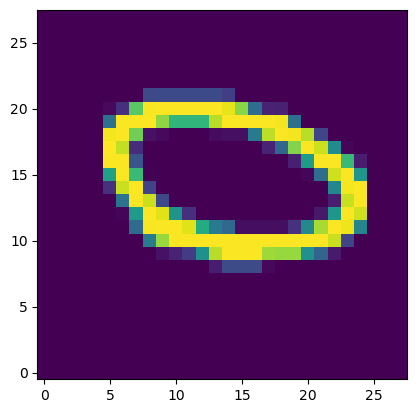

10-element Vector{Float64}:
 0.7708869584747235
 1.4462628823967599e-5
 0.005532176334620805
 0.007343098417607034
 0.001393771675820522
 0.10244912131250336
 0.0036833502709218676
 0.0020874398562402453
 0.10224661512171727
 0.0043630059070213535

In [9]:
# show final prediction
using StatsFuns: softmax
input = convert(Matrix{Float64}, train_x[:,:,1001])
plt.imshow(input, origin="lower")
softmax(forward!(model, vec(input)))